In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

In [2]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
df = pd.read_csv('../weather.csv', parse_dates=['datetime'], index_col='datetime')

In [4]:
df.shape

(175320, 5)

In [5]:
df.values

array([[   5.75,  336.01,    0.  ,   16.85, -999.  ],
       [   6.2 ,  342.02,    0.  ,   16.21, -999.  ],
       [   6.  ,  349.8 ,    0.  ,   15.55, -999.  ],
       ...,
       [   5.39,  320.77,    0.  ,   20.14, -999.  ],
       [   5.61,  324.76,    0.  ,   19.69, -999.  ],
       [   5.91,  329.57,    0.  ,   19.2 , -999.  ]])

In [6]:
df.head()

,Wind Speed,Wind Direction,Solar Irradiance,Temperature,Clearness index
datetime,,,,,
2004-01-01 00:00:00,5.75,336.01,0.0,16.85,-999.0
2004-01-01 01:00:00,6.20,342.02,0.0,16.21,-999.0
2004-01-01 02:00:00,6.00,349.80,0.0,15.55,-999.0
2004-01-01 03:00:00,5.44,357.20,0.0,15.05,-999.0
2004-01-01 04:00:00,4.76,2.92,0.0,14.80,-999.0


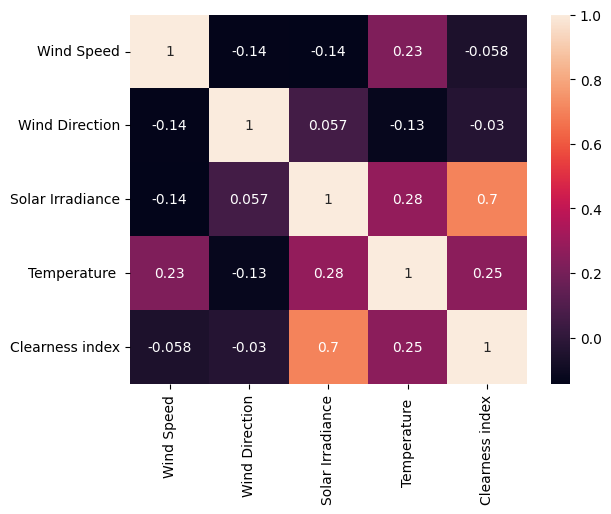

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df.corr(), annot=True)
plt.show()

In [8]:
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, n_steps_in, n_steps_out):
        self.n_steps_in = n_steps_in
        self.n_steps_out = n_steps_out
        self.sequences = sequences
        self.X, self.y = self.split_sequences()

    def split_sequences(self):
        X, y = [], []
        for i in range(len(self.sequences)):
            end_ix = i + self.n_steps_in
            out_end_ix = end_ix + self.n_steps_out - 1
            if out_end_ix + 1 > len(self.sequences):
                break
            seq_x = self.sequences[i:end_ix, 1:5]
            seq_y = self.sequences[end_ix:out_end_ix+1, 0]
            X.append(seq_x)
            y.append(seq_y)
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [9]:
train_df = df.loc[ :'2019-12-31 23:00:00']
val_df   = df.loc['2020-01-01 00:00:00':'2021-12-31 23:00:00']
test_df  = df.loc['2022-01-01 00:00:00':]

In [10]:
train_df.head()

,Wind Speed,Wind Direction,Solar Irradiance,Temperature,Clearness index
datetime,,,,,
2004-01-01 00:00:00,5.75,336.01,0.0,16.85,-999.0
2004-01-01 01:00:00,6.20,342.02,0.0,16.21,-999.0
2004-01-01 02:00:00,6.00,349.80,0.0,15.55,-999.0
2004-01-01 03:00:00,5.44,357.20,0.0,15.05,-999.0
2004-01-01 04:00:00,4.76,2.92,0.0,14.80,-999.0


In [11]:
test_df.head()
test_df.tail()

,Wind Speed,Wind Direction,Solar Irradiance,Temperature,Clearness index
datetime,,,,,
2023-12-31 19:00:00,4.99,323.02,0.0,21.12,-999.0
2023-12-31 20:00:00,5.25,320.25,0.0,20.61,-999.0
2023-12-31 21:00:00,5.39,320.77,0.0,20.14,-999.0
2023-12-31 22:00:00,5.61,324.76,0.0,19.69,-999.0
2023-12-31 23:00:00,5.91,329.57,0.0,19.20,-999.0


In [12]:
# from sklearn.preprocessing import StandardScaler,MinMaxScaler

# feature_scaler = StandardScaler()
# target_scaler = MinMaxScaler()

# # Separate features and target
# X_train = train_df.iloc[:, 1:5]
# y_train = train_df.iloc[:, 0:1]

# # Fit scalers
# X_train_scaled = feature_scaler.fit_transform(X_train)
# y_train_scaled = target_scaler.fit_transform(y_train)

# # Transform val and test using same scaler (IMPORTANT)
# X_val_scaled = feature_scaler.transform(val_df.iloc[:, 1:5])
# y_val_scaled = target_scaler.transform(val_df.iloc[:, 0:1])

# X_test_scaled = feature_scaler.transform(test_df.iloc[:, 1:5])
# y_test_scaled = target_scaler.transform(test_df.iloc[:, 0:1])

# # Combine back into arrays
# train_scaled = np.hstack([X_train_scaled, y_train_scaled])
# val_scaled   = np.hstack([X_val_scaled, y_val_scaled])
# test_scaled  = np.hstack([X_test_scaled, y_test_scaled])


In [13]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

feature_scaler = StandardScaler()
target_scaler = MinMaxScaler()

X_train = train_df.iloc[:, 1:5]
y_train = train_df.iloc[:, 0:1]

feature_scaler.fit(X_train)  
target_scaler.fit(y_train)  

# Then transform all sets using these fitted scalers
X_train_scaled = feature_scaler.transform(X_train)
y_train_scaled = target_scaler.transform(y_train)

X_val_scaled = feature_scaler.transform(val_df.iloc[:, 1:5])  
y_val_scaled = target_scaler.transform(val_df.iloc[:, 0:1])

X_test_scaled = feature_scaler.transform(test_df.iloc[:, 1:5])
y_test_scaled = target_scaler.transform(test_df.iloc[:, 0:1])

train_scaled = np.hstack([y_train_scaled, X_train_scaled])
val_scaled   = np.hstack([y_val_scaled, X_val_scaled])
test_scaled  = np.hstack([y_test_scaled, X_test_scaled])

In [14]:
y_train_scaled

array([[0.22837784],
       [0.24631327],
       [0.23834197],
       ...,
       [0.1865285 ],
       [0.17895576],
       [0.17058589]])

In [15]:
train_scaled

array([[ 0.22837784,  1.33635043, -0.73357256, -2.46362271, -1.04561492],
       [ 0.24631327,  1.40337731, -0.73357256, -2.63367777, -1.04561492],
       [ 0.23834197,  1.49014423, -0.73357256, -2.80904705, -1.04561492],
       ...,
       [ 0.1865285 ,  0.88935581, -0.73357256, -1.62131874, -1.04561492],
       [ 0.17895576,  0.97188476, -0.73357256, -1.69837494, -1.04561492],
       [ 0.17058589,  1.05854015, -0.73357256, -1.77277403, -1.04561492]])

In [16]:
from torch.utils.data import DataLoader

n_steps_in = 24 * 7 * 4
n_steps_out = 24
batch_size = 64

train_dataset = TimeSeriesDataset(train_scaled, n_steps_in, n_steps_out)
val_dataset   = TimeSeriesDataset(val_scaled, n_steps_in, n_steps_out)
test_dataset  = TimeSeriesDataset(test_scaled, n_steps_in, n_steps_out)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False,num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

/tmp/ipykernel_43705/3384386690.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [17]:
print("Train dataset length", train_dataset.__len__())
print("Validation dataset length", val_dataset.__len__())
print("Test dataset length", test_dataset.__len__())

Train dataset length 139561
Validation dataset length 16849
Test dataset length 16825


In [18]:
train_dataset[0]

(tensor([[ 1.3364, -0.7336, -2.4636, -1.0456],
         [ 1.4034, -0.7336, -2.6337, -1.0456],
         [ 1.4901, -0.7336, -2.8090, -1.0456],
         ...,
         [ 1.3884, -0.7336, -2.3361, -1.0456],
         [ 1.4545, -0.7336, -2.5061, -1.0456],
         [ 1.5187, -0.7336, -2.6762, -1.0456]]),
 tensor([0.3212, 0.3117, 0.2953, 0.2790, 0.2595, 0.2427, 0.2292, 0.2136, 0.1961,
         0.2423, 0.2499, 0.2232, 0.1969, 0.1718, 0.1467, 0.1287, 0.1216, 0.1311,
         0.1483, 0.1491, 0.1483, 0.1702, 0.1969, 0.2192]))

In [19]:
test_dataset[-1]

(tensor([[ 1.5634, -0.7336, -0.8906, -1.0456],
         [-2.2578, -0.7336, -1.0394, -1.0456],
         [-2.1199, -0.7336, -1.1696, -1.0456],
         ...,
         [ 1.2378, -0.7336, -1.2068, -1.0456],
         [ 1.2740, -0.7336, -1.3370, -1.0456],
         [ 1.3322, -0.7336, -1.4831, -1.0456]]),
 tensor([0.1363, 0.1383, 0.1371, 0.1335, 0.1291, 0.1240, 0.1244, 0.1339, 0.1351,
         0.1451, 0.1463, 0.1403, 0.1343, 0.1295, 0.1315, 0.1391, 0.1511, 0.1690,
         0.1861, 0.1981, 0.2084, 0.2140, 0.2228, 0.2348]))

In [20]:
val_dataset[0]

(tensor([[ 1.1563, -0.7336, -1.8498, -1.0456],
         [ 1.2772, -0.7336, -1.9322, -1.0456],
         [ 1.3957, -0.7336, -2.0119, -1.0456],
         ...,
         [-2.3146, -0.7336, -1.7754, -1.0456],
         [-2.0085, -0.7336, -1.8950, -1.0456],
         [-1.7550, -0.7336, -2.0199, -1.0456]]),
 tensor([0.0570, 0.0387, 0.0124, 0.0175, 0.0355, 0.0434, 0.0646, 0.0976, 0.1100,
         0.1044, 0.0965, 0.0969, 0.0984, 0.1076, 0.1120, 0.0965, 0.0650, 0.0299,
         0.0120, 0.0195, 0.0411, 0.0590, 0.0697, 0.0853]))

In [21]:
# Check the length
print(len(train_dataset))

# Check one sample
X_sample, y_sample = train_dataset[0]
print("Input sequence shape:", X_sample.shape)
print("Output sequence shape:", y_sample.shape)

print("Input sample (X):", X_sample)
print("Output sample (y):", y_sample)

139561
Input sequence shape: torch.Size([672, 4])
Output sequence shape: torch.Size([24])
Input sample (X): tensor([[ 1.3364, -0.7336, -2.4636, -1.0456],
        [ 1.4034, -0.7336, -2.6337, -1.0456],
        [ 1.4901, -0.7336, -2.8090, -1.0456],
        ...,
        [ 1.3884, -0.7336, -2.3361, -1.0456],
        [ 1.4545, -0.7336, -2.5061, -1.0456],
        [ 1.5187, -0.7336, -2.6762, -1.0456]])
Output sample (y): tensor([0.3212, 0.3117, 0.2953, 0.2790, 0.2595, 0.2427, 0.2292, 0.2136, 0.1961,
        0.2423, 0.2499, 0.2232, 0.1969, 0.1718, 0.1467, 0.1287, 0.1216, 0.1311,
        0.1483, 0.1491, 0.1483, 0.1702, 0.1969, 0.2192])


In [22]:
# Check the length
print(len(val_dataset))

# Check one sample
X_sample, y_sample = val_dataset[0]
print("Input sequence shape:", X_sample.shape)
print("Output sequence shape:", y_sample.shape)

print("Input sample (X):", X_sample)
print("Output sample (y):", y_sample)

16849
Input sequence shape: torch.Size([672, 4])
Output sequence shape: torch.Size([24])
Input sample (X): tensor([[ 1.1563, -0.7336, -1.8498, -1.0456],
        [ 1.2772, -0.7336, -1.9322, -1.0456],
        [ 1.3957, -0.7336, -2.0119, -1.0456],
        ...,
        [-2.3146, -0.7336, -1.7754, -1.0456],
        [-2.0085, -0.7336, -1.8950, -1.0456],
        [-1.7550, -0.7336, -2.0199, -1.0456]])
Output sample (y): tensor([0.0570, 0.0387, 0.0124, 0.0175, 0.0355, 0.0434, 0.0646, 0.0976, 0.1100,
        0.1044, 0.0965, 0.0969, 0.0984, 0.1076, 0.1120, 0.0965, 0.0650, 0.0299,
        0.0120, 0.0195, 0.0411, 0.0590, 0.0697, 0.0853])


In [23]:
# Check the length
print(len(test_dataset))

# Check one sample
X_sample, y_sample = test_dataset[-1]
print("Input sequence shape:", X_sample.shape)
print("Output sequence shape:", y_sample.shape)

print("Input sample (X):", X_sample)
print("Output sample (y):", y_sample)

16825
Input sequence shape: torch.Size([672, 4])
Output sequence shape: torch.Size([24])
Input sample (X): tensor([[ 1.5634, -0.7336, -0.8906, -1.0456],
        [-2.2578, -0.7336, -1.0394, -1.0456],
        [-2.1199, -0.7336, -1.1696, -1.0456],
        ...,
        [ 1.2378, -0.7336, -1.2068, -1.0456],
        [ 1.2740, -0.7336, -1.3370, -1.0456],
        [ 1.3322, -0.7336, -1.4831, -1.0456]])
Output sample (y): tensor([0.1363, 0.1383, 0.1371, 0.1335, 0.1291, 0.1240, 0.1244, 0.1339, 0.1351,
        0.1451, 0.1463, 0.1403, 0.1343, 0.1295, 0.1315, 0.1391, 0.1511, 0.1690,
        0.1861, 0.1981, 0.2084, 0.2140, 0.2228, 0.2348])


In [24]:
# Get one batch from DataLoader
for X_batch, y_batch in train_loader:
    print("Batch Input shape:", X_batch.shape)
    print(X_batch)
    print("Batch Output shape:", y_batch.shape)
    print(y_batch)
    
    n_steps_in = X_batch.shape[1]
    n_features = X_batch.shape[2]
    n_steps_out = y_batch.shape[1]
    
    print(n_steps_in, n_features, n_steps_out)
    break


Batch Input shape: torch.Size([64, 672, 4])
tensor([[[ 1.3364, -0.7336, -2.4636, -1.0456],
         [ 1.4034, -0.7336, -2.6337, -1.0456],
         [ 1.4901, -0.7336, -2.8090, -1.0456],
         ...,
         [ 1.3884, -0.7336, -2.3361, -1.0456],
         [ 1.4545, -0.7336, -2.5061, -1.0456],
         [ 1.5187, -0.7336, -2.6762, -1.0456]],

        [[ 1.4034, -0.7336, -2.6337, -1.0456],
         [ 1.4901, -0.7336, -2.8090, -1.0456],
         [ 1.5727, -0.7336, -2.9419, -1.0456],
         ...,
         [ 1.4545, -0.7336, -2.5061, -1.0456],
         [ 1.5187, -0.7336, -2.6762, -1.0456],
         [ 1.5674, -0.7336, -2.8569, -1.0456]],

        [[ 1.4901, -0.7336, -2.8090, -1.0456],
         [ 1.5727, -0.7336, -2.9419, -1.0456],
         [-2.3785, -0.7336, -3.0083, -1.0456],
         ...,
         [ 1.5187, -0.7336, -2.6762, -1.0456],
         [ 1.5674, -0.7336, -2.8569, -1.0456],
         [-2.4110, -0.7336, -3.0376, -1.0456]],

        ...,

        [[ 1.3367,  1.5439, -1.3370,  0.9568],
 

In [25]:
for X_batch, y_batch in val_loader:
    print("Batch Input shape:", X_batch.shape)
    print(X_batch)
    print("Batch Output shape:", y_batch.shape)
    print(y_batch)
    
    n_steps_in = X_batch.shape[1]
    n_features = X_batch.shape[2]
    n_steps_out = y_batch.shape[1]
    
    print(n_steps_in, n_features, n_steps_out)
    break

Batch Input shape: torch.Size([64, 672, 4])
tensor([[[ 1.1563, -0.7336, -1.8498, -1.0456],
         [ 1.2772, -0.7336, -1.9322, -1.0456],
         [ 1.3957, -0.7336, -2.0119, -1.0456],
         ...,
         [-2.3146, -0.7336, -1.7754, -1.0456],
         [-2.0085, -0.7336, -1.8950, -1.0456],
         [-1.7550, -0.7336, -2.0199, -1.0456]],

        [[ 1.2772, -0.7336, -1.9322, -1.0456],
         [ 1.3957, -0.7336, -2.0119, -1.0456],
         [ 1.4556, -0.7336, -2.0810, -1.0456],
         ...,
         [-2.0085, -0.7336, -1.8950, -1.0456],
         [-1.7550, -0.7336, -2.0199, -1.0456],
         [-1.5639, -0.7336, -2.1155, -1.0456]],

        [[ 1.3957, -0.7336, -2.0119, -1.0456],
         [ 1.4556, -0.7336, -2.0810, -1.0456],
         [ 1.4795, -0.7336, -2.1421, -1.0456],
         ...,
         [-1.7550, -0.7336, -2.0199, -1.0456],
         [-1.5639, -0.7336, -2.1155, -1.0456],
         [-1.3265, -0.7336, -2.1846, -1.0456]],

        ...,

        [[-2.0696, -0.2369, -1.2201,  0.9557],
 

In [26]:
for X_batch, y_batch in test_loader:
    print("Batch Input shape:", X_batch.shape)
    print(X_batch)
    print("Batch Output shape:", y_batch.shape)
    print(y_batch)
    
    n_steps_in = X_batch.shape[1]
    n_features = X_batch.shape[2]
    n_steps_out = y_batch.shape[1]
    
    print(n_steps_in, n_features, n_steps_out)
    break

Batch Input shape: torch.Size([64, 672, 4])
tensor([[[ 1.4395, -0.7336, -2.2325, -1.0456],
         [ 1.4640, -0.7336, -2.3733, -1.0456],
         [ 1.4864, -0.7336, -2.4689, -1.0456],
         ...,
         [ 1.4048, -0.7336, -2.4131, -1.0456],
         [ 1.4134, -0.7336, -2.5061, -1.0456],
         [ 1.4140, -0.7336, -2.5912, -1.0456]],

        [[ 1.4640, -0.7336, -2.3733, -1.0456],
         [ 1.4864, -0.7336, -2.4689, -1.0456],
         [ 1.5011, -0.7336, -2.5407, -1.0456],
         ...,
         [ 1.4134, -0.7336, -2.5061, -1.0456],
         [ 1.4140, -0.7336, -2.5912, -1.0456],
         [ 1.4181, -0.7336, -2.6762, -1.0456]],

        [[ 1.4864, -0.7336, -2.4689, -1.0456],
         [ 1.5011, -0.7336, -2.5407, -1.0456],
         [ 1.5120, -0.7336, -2.6098, -1.0456],
         ...,
         [ 1.4140, -0.7336, -2.5912, -1.0456],
         [ 1.4181, -0.7336, -2.6762, -1.0456],
         [ 1.4405, -0.7336, -2.7612, -1.0456]],

        ...,

        [[ 1.2023,  1.5979, -1.1776,  0.9569],
 

In [27]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class EnhancedLSTMForecaster(nn.Module):
#     def __init__(self, n_features, n_steps_in, n_steps_out, hidden_dim=256, num_layers=3, dropout=0.3):
#         super().__init__()
#         self.n_steps_out = n_steps_out
#         self.num_layers = num_layers
        
#         # Encoder
#         self.encoder = nn.LSTM(
#             input_size=n_features,
#             hidden_size=hidden_dim,
#             num_layers=num_layers,
#             batch_first=True,
#             dropout=dropout if num_layers > 1 else 0
#         )
        
#         # Decoder 
#         self.decoder = nn.LSTM(
#             input_size=hidden_dim,
#             hidden_size=hidden_dim,
#             num_layers=num_layers,
#             batch_first=True,
#             dropout=dropout if num_layers > 1 else 0
#         )
        
#         # Attention
#         self.attention = nn.Linear(hidden_dim, 1, bias=False)
        
#         # Output 
#         # self.fc = nn.Linear(hidden_dim * 2, 1)
#         self.fc = nn.Sequential(
#             nn.Linear(hidden_dim * 2, 1),
#             nn.ReLU()  
#             )
        
#         # Initialize weights
#         for name, param in self.named_parameters():
#             if 'weight' in name and param.dim() > 1:
#                 nn.init.xavier_normal_(param)
#             elif 'bias' in name:
#                 nn.init.constant_(param, 0.1)

#     def forward(self, x):
#         # x shape: [batch, seq_len, features]
        
#         # Encoder
#         enc_out, (h_n, c_n) = self.encoder(x)  # enc_out: [batch, seq_len, hidden_dim]
        
#         # Decoder In
#         decoder_in = h_n[-1].unsqueeze(1).repeat(1, self.n_steps_out, 1)  # [batch, n_steps_out, hidden_dim]
        
#         # Decoder Out
#         decoder_out, _ = self.decoder(decoder_in, (h_n, c_n))  # [batch, n_steps_out, hidden_dim]
        
#         # Attention
#         attn_scores = F.softmax(self.attention(enc_out), dim=1)  # [batch, seq_len, 1]
#         context = torch.bmm(attn_scores.transpose(1, 2), enc_out)  # [batch, 1, hidden_dim]
#         context = context.expand(-1, self.n_steps_out, -1)  # [batch, n_steps_out, hidden_dim]
        
#         # Combine and predict
#         combined = torch.cat([context, decoder_out], dim=-1)  # [batch, n_steps_out, hidden_dim * 2]
#         predictions = self.fc(combined).squeeze(-1)  # [batch, n_steps_out]
        
#         return predictions  # [batch, n_steps_out]

In [28]:
import torch
import torch.nn as nn
class SimpleLSTMForecaster(nn.Module):
    def __init__(self, n_features, n_steps_in, n_steps_out, hidden_dim=128, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, n_steps_out)

    def forward(self, x):
        # x: [batch_size, seq_len, n_features]
        out, (h_n, c_n) = self.lstm(x)  # h_n: [num_layers, batch_size, hidden_dim]
        last_hidden = h_n[-1]  # [batch_size, hidden_dim]
        output = self.fc(last_hidden)  # [batch_size, n_steps_out]
        return output


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time
import os

def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, device, patience=10, min_lr=1e-6):
    model.to(device)
    best_val_loss = float('inf')
    best_model_path = "best_wind_model.pth"
    trigger_times = 0
    
    # Initialize learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience//2, min_lr=min_lr)
    
    train_losses = []
    val_losses = []
    val_maes = []  
    epoch_times = []

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        
        # Gradient clipping value
        clip_value = 1.0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            
            # Ensure shapes match 
            if outputs.ndim > y_batch.ndim:
                outputs = outputs.squeeze(-1)
            
            loss = criterion(outputs, y_batch)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_mae = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                preds = model(X_val)
                
                if preds.ndim > y_val.ndim:
                    preds = preds.squeeze(-1)
                
                val_loss += criterion(preds, y_val).item() * X_val.size(0)
                val_mae += mean_absolute_error(
                    y_val.cpu().numpy(), 
                    preds.cpu().numpy()
                ) * X_val.size(0)
        
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_mae = val_mae / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        val_maes.append(epoch_val_mae)
        
        # Update learning rate
        scheduler.step(epoch_val_loss)
        
        epoch_time = time.time() - start_time
        epoch_times.append(epoch_time)
        
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} | "
              f"Val MAE: {epoch_val_mae:.4f} | "
              f"Time: {epoch_time:.2f}s")
        
        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_val_loss,
            }, best_model_path)
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Load best model
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title("Loss over Epochs")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(val_maes, label='Val MAE', color='orange')
    plt.title("Validation MAE over Epochs")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nTraining completed. Best validation loss: {best_val_loss:.4f}")
    print(f"Average epoch time: {np.mean(epoch_times):.2f}s")
    
    return model

Epoch 1/100 | Train Loss: 0.0090 | Val Loss: 0.0131 | Val MAE: 0.0835 | Time: 9.75s
Epoch 2/100 | Train Loss: 0.0085 | Val Loss: 0.0098 | Val MAE: 0.0730 | Time: 9.72s
Epoch 3/100 | Train Loss: 0.0076 | Val Loss: 0.0085 | Val MAE: 0.0681 | Time: 9.80s
Epoch 4/100 | Train Loss: 0.0073 | Val Loss: 0.0080 | Val MAE: 0.0658 | Time: 9.76s
Epoch 5/100 | Train Loss: 0.0071 | Val Loss: 0.0077 | Val MAE: 0.0647 | Time: 9.74s
Epoch 6/100 | Train Loss: 0.0070 | Val Loss: 0.0075 | Val MAE: 0.0639 | Time: 9.83s
Epoch 7/100 | Train Loss: 0.0069 | Val Loss: 0.0074 | Val MAE: 0.0634 | Time: 9.81s
Epoch 8/100 | Train Loss: 0.0068 | Val Loss: 0.0074 | Val MAE: 0.0631 | Time: 9.87s
Epoch 9/100 | Train Loss: 0.0067 | Val Loss: 0.0073 | Val MAE: 0.0628 | Time: 9.92s
Epoch 10/100 | Train Loss: 0.0066 | Val Loss: 0.0072 | Val MAE: 0.0625 | Time: 9.85s
Epoch 11/100 | Train Loss: 0.0066 | Val Loss: 0.0072 | Val MAE: 0.0622 | Time: 9.75s
Epoch 12/100 | Train Loss: 0.0065 | Val Loss: 0.0071 | Val MAE: 0.0619 | T

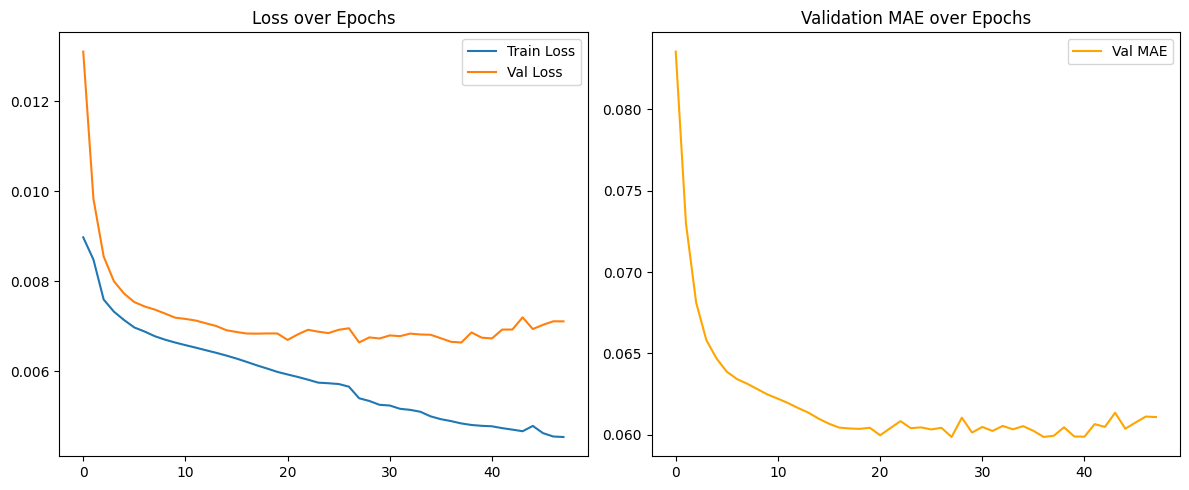


Training completed. Best validation loss: 0.0066
Average epoch time: 9.86s


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleLSTMForecaster(
    n_features=n_features,
    n_steps_in=n_steps_in,
    n_steps_out=n_steps_out,
    hidden_dim=128
).to(device)

criterion = nn.MSELoss()  
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)  

model = train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=100,  
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    patience=10,  
    min_lr=1e-6
)

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(model, loader, criterion, device, scaler=None):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_targets = []
    batch_metrics = []

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            
            # Forward pass
            preds = model(X)
            
            # Calculate loss
            loss = criterion(preds, y)
            total_loss += loss.item() * X.size(0)
            
            # Store predictions and targets
            preds_np = preds.cpu().numpy()
            targets_np = y.cpu().numpy()
            
            # Inverse transform if scaler provided
            if scaler is not None:
                preds_np = scaler.inverse_transform(preds_np.reshape(-1, 1)).flatten()
                targets_np = scaler.inverse_transform(targets_np.reshape(-1, 1)).flatten()
            
            all_preds.append(preds_np)
            all_targets.append(targets_np)
            
            # Calculate batch metrics
            batch_metrics.append({
                'mae': mean_absolute_error(targets_np, preds_np),
                'rmse': np.sqrt(mean_squared_error(targets_np, preds_np)),
                'r2': r2_score(targets_np, preds_np)
            })

    # Concatenate all predictions
    preds = np.concatenate(all_preds)
    targets = np.concatenate(all_targets)
    
    # Calculate overall metrics
    metrics = {
        'loss': total_loss / len(loader.dataset),
        'mae': mean_absolute_error(targets, preds),
        'rmse': np.sqrt(mean_squared_error(targets, preds)),
        'r2': r2_score(targets, preds),
        'max_error': np.max(np.abs(targets - preds)),
        'std_error': np.std(targets - preds),
        'batch_metrics': batch_metrics
    }
    
    print(f"Evaluation Results:")
    print(f"- Loss: {metrics['loss']:.4f}")
    print(f"- MAE: {metrics['mae']:.4f}")
    print(f"- RMSE: {metrics['rmse']:.4f}")
    print(f"- R²: {metrics['r2']:.4f}")
    print(f"- Max Error: {metrics['max_error']:.4f}")
    print(f"- Error Std: {metrics['std_error']:.4f}")
    
    return {
        'metrics': metrics,
        'predictions': preds,
        'targets': targets
    }

In [32]:

results = evaluate_model(
    model=model,
    loader=test_loader,
    criterion=nn.MSELoss(), 
    device=device,
)

Evaluation Results:
- Loss: 0.0062
- MAE: 0.0576
- RMSE: 0.0789
- R²: 0.3145
- Max Error: 0.6028
- Error Std: 0.0789


In [33]:

def evaluate_concise(model, loader, device, scaler=None):
    model.eval()
    
    preds, targets = [], []
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            preds.append(model(X).cpu().numpy())
            targets.append(y.cpu().numpy())
    
    preds = np.concatenate(preds).flatten()
    targets = np.concatenate(targets).flatten()
    
    if scaler:
        preds = scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
        targets = scaler.inverse_transform(targets.reshape(-1, 1)).flatten()
    
    metrics = {
        'MAE': mean_absolute_error(targets, preds),
        'RMSE': np.sqrt(mean_squared_error(targets, preds)),
        'R2': r2_score(targets, preds)
    }
    
    print(f"MAE: {metrics['MAE']:.3f}, RMSE: {metrics['RMSE']:.3f}, R²: {metrics['R2']:.3f}")
    return metrics, preds, targets

In [34]:
evaluate , preds, targets= evaluate_concise(
    model=model,
    loader=test_loader,
    device=device,
    
)

MAE: 0.058, RMSE: 0.079, R²: 0.314


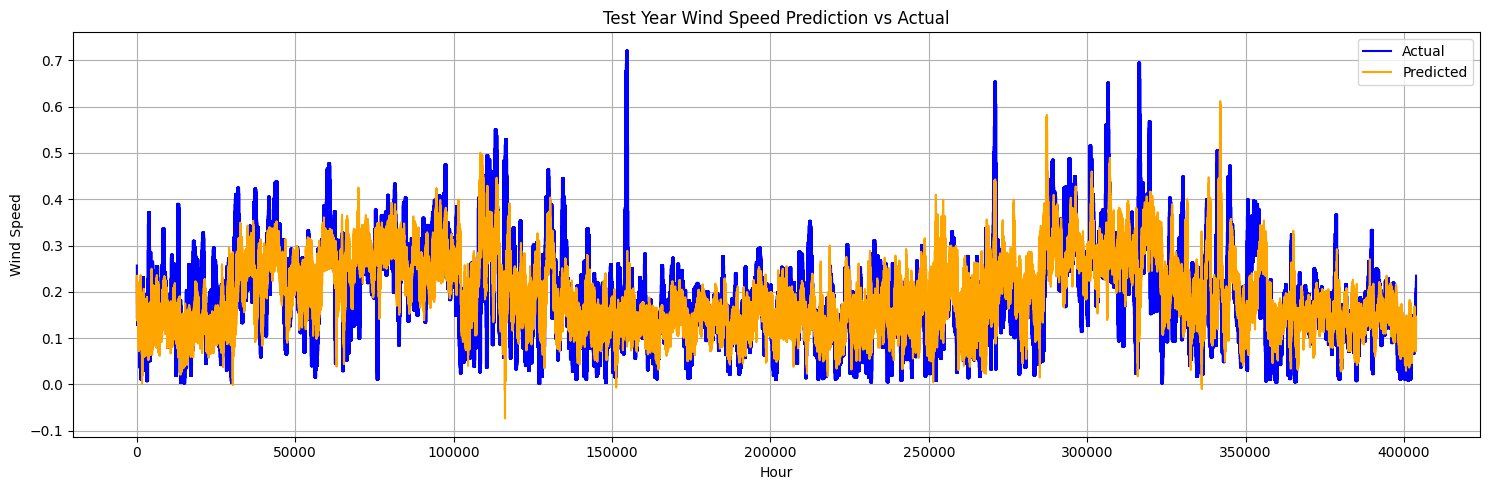

In [40]:
plt.figure(figsize=(15, 5))
plt.plot(targets, label='Actual', color='blue')
plt.plot(preds, label='Predicted', color='orange')
plt.title('Test Year Wind Speed Prediction vs Actual')
plt.xlabel('Hour')
plt.ylabel('Wind Speed')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [45]:
from sklearn.preprocessing import StandardScaler
import os
from datetime import timedelta


def compute_hourly_feature_averages(df, feature_columns):
    """Compute average feature values for each hour of the year."""
    df = df.copy()
    df['hour_of_year'] = (df.index.dayofyear - 1) * 24 + df.index.hour
    return df.groupby('hour_of_year')[feature_columns].mean()

def estimate_future_features(future_dates, feature_averages, feature_columns, feature_scaler):
    """Estimate scaled features for future dates using historical averages."""
    hour_of_year = (future_dates.dayofyear - 1) * 24 + future_dates.hour
    estimated_features = feature_averages.loc[hour_of_year, feature_columns].values
    return feature_scaler.transform(estimated_features)

# Parameters
n_step_in = 24*4*7  
n_step_out = 24  
hours_to_predict = 8760  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "best_wind_model.pth"
output_csv = "wind_speed_predictions_year4.csv"


# Verify expected columns
expected_columns = ['Wind Speed', 'Wind Direction', 'Solar Irradiance', 'Temperature ', 'Clearness index']
if not all(col in df.columns for col in expected_columns):
    raise ValueError(f"DataFrame missing required columns. Expected: {expected_columns}")

# Compute historical feature averages
feature_columns = ['Wind Direction', 'Solar Irradiance', 'Temperature ', 'Clearness index']
feature_averages = compute_hourly_feature_averages(df, feature_columns)

feature_scaler = StandardScaler()
target_scaler = MinMaxScaler()

X = df[feature_columns].values  
y = df['Wind Speed'].values.reshape(-1, 1)  
X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y)
data_scaled = np.hstack([y_scaled, X_scaled])

if len(data_scaled) < n_step_in:
    raise ValueError(f"Data has {len(data_scaled)} rows, but n_step_in={n_step_in} required.")


current_input = data_scaled[-n_step_in:, :] 

# Load model
try:
    model = SimpleLSTMForecaster(n_features, n_step_in, n_step_out).to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
except FileNotFoundError:
    raise FileNotFoundError(f"Model file not found at {model_path}")
except Exception as e:
    raise RuntimeError(f"Error loading model: {e}")

# Initialize predictions
all_predictions = []
prediction_dates = pd.date_range(
    start=df.index[-1] + timedelta(hours=1),
    periods=hours_to_predict,
    freq="h"
)

# Iterative prediction
for step in range((hours_to_predict + n_step_out - 1) // n_step_out):
    input_features = current_input[:, 1:] 
    input_tensor = torch.tensor(input_features, dtype=torch.float32).unsqueeze(0).to(device) 

    # Predict
    with torch.no_grad():
        pred_scaled = model(input_tensor).cpu().numpy()

    # Inverse scale predictions
    pred_scaled = pred_scaled.reshape(-1, 1) 
    pred_unscaled = target_scaler.inverse_transform(pred_scaled).flatten() 

    remaining = hours_to_predict - len(all_predictions)
    n_to_keep = min(n_step_out, remaining)
    all_predictions.extend(pred_unscaled[:n_to_keep])

    if len(all_predictions) >= hours_to_predict:
        break

    future_dates = prediction_dates[len(all_predictions) - n_to_keep:len(all_predictions)]
    estimated_features_scaled = estimate_future_features(
        future_dates, feature_averages, feature_columns, feature_scaler
    )

    pred_scaled = pred_scaled[:n_to_keep, :] 
    next_sequence = np.hstack([pred_scaled, estimated_features_scaled])  
    current_input = np.vstack([current_input[n_to_keep:, :], next_sequence])  

# DataFrame
pred_df = pd.DataFrame({
    "DateTime": prediction_dates[:hours_to_predict],
    "WindSpeed_Predicted": all_predictions
})

# Save to CSV
try:
    pred_df.to_csv(output_csv, index=False)
    print(f"Predictions saved to {output_csv}")
except Exception as e:
    raise RuntimeError(f"Error saving CSV: {e}")



Predictions saved to wind_speed_predictions_year4.csv


In [46]:
print(pred_df.tail())

                DateTime  WindSpeed_Predicted
8755 2024-12-30 19:00:00             4.002686
8756 2024-12-30 20:00:00             3.986317
8757 2024-12-30 21:00:00             3.997798
8758 2024-12-30 22:00:00             4.046721
8759 2024-12-30 23:00:00             4.068114


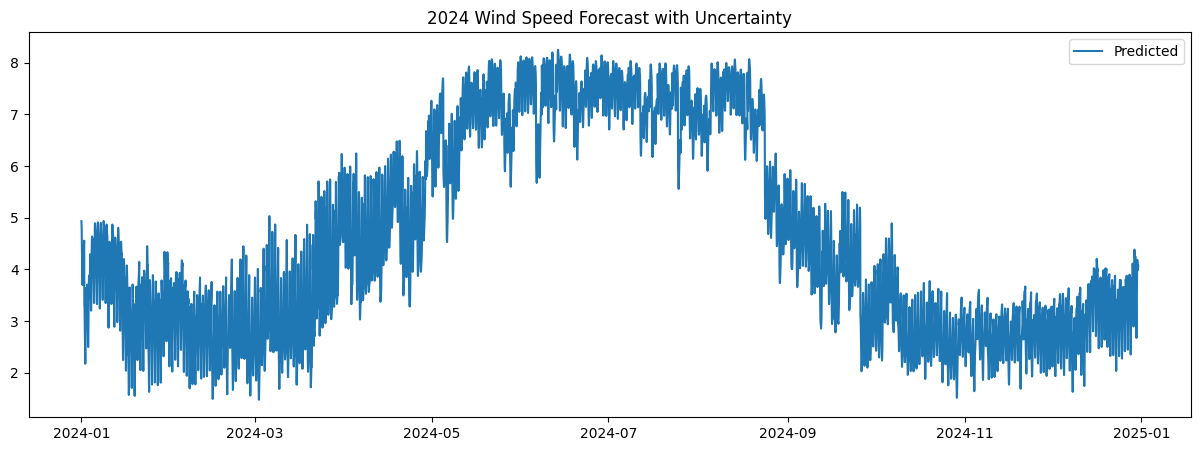

In [47]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(pred_df['DateTime'], pred_df['WindSpeed_Predicted'], label='Predicted')
plt.title('2024 Wind Speed Forecast with Uncertainty')
plt.legend()
plt.show()